In [2]:
%load_ext autoreload
%autoreload 2

# Placeholder graphs
Graphs with dummy data

# Resources
- https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns

In [4]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
sns.set(context="talk", style="ticks", font_scale=1.5)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [5]:
style.available

['seaborn-notebook',
 '_classic_test',
 'bmh',
 'seaborn-dark',
 'seaborn-bright',
 'grayscale',
 'tableau-colorblind10',
 'dark_background',
 'seaborn-pastel',
 'seaborn-white',
 'seaborn-muted',
 'Solarize_Light2',
 'fast',
 'seaborn',
 'seaborn-colorblind',
 'seaborn-whitegrid',
 'seaborn-talk',
 'seaborn-paper',
 'ggplot',
 'seaborn-dark-palette',
 'seaborn-poster',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'seaborn-deep',
 'fivethirtyeight',
 'classic']

In [6]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

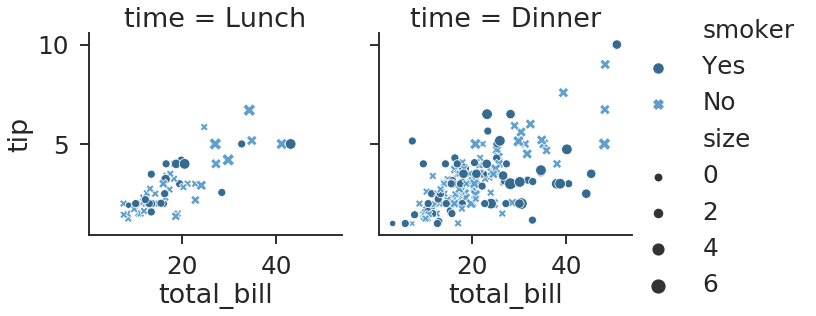

In [7]:
tips = sns.load_dataset("tips")
sns.relplot(x="total_bill", y="tip", col="time",
            hue="smoker", style="smoker", size="size",
            data=tips, palette=("Blues_d"));

# Chapter 0: Overview

In [8]:
benchmarks = ["500.perlbench_r", "502.gcc_r", "503.bwaves_r", "527.cam4_r", "541.leela_r", "549.fotonik3d_r", "554.roms_r", "557.xz_r"]
classifiers = ["SimPoint", "BBV", "INS", "BR", "PROC"]
colors = {
    "SimPoint": "blue",
    "BBV": "red",
    "INS": "green",
    "BR": "orange",
    "PROC": "purple"
}

## What are phases?

In [9]:
dfs = {}
directory = "../tmp/perf"

max_name = ""
max_rows = 0

for path in os.listdir(directory):
    if path[-3:] != "csv":
        continue
        
    name = path.replace(".csv", "")
    
    print("Processing {}".format(name))
    
    # Read data
    dfs[name] = pd.read_csv(os.path.join(directory, path), index_col=False, names=["duration", "value", "unit", "event", "d1", "d2", "d3", "d4"], skiprows=1)
    
    # Generate timestamps from duration by taking cumulative sum
    timestamps = pd.DataFrame([dfs[name].duration.unique(),dfs[name].duration.unique().cumsum()]).transpose()
    timestamps.columns = ["duration", "timestamp"]
    
    # Merge with data
    dfs[name] = dfs[name].merge(timestamps)
    
    # Pivot to reshape into wide format
    dfs[name] = dfs[name].pivot_table(index="timestamp", columns="event", values="value", aggfunc="first")
    
    # Remove periods that don't have instructions:u counted
    dfs[name] = dfs[name][dfs[name]["instructions:u"] != "<not counted>"]
    dfs[name] = dfs[name].astype({"instructions:u": "int64"})
    
    # Cumulative instructions
    dfs[name]["instructions"] = dfs[name]["instructions:u"].cumsum()
    
    if dfs[name].shape[0] > max_rows:
        max_rows = dfs[name].shape[0]
        max_name = name

Processing 657.xz_s.1.energy


/home/dsuo/miniconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Processing 657.xz_s.1.llc


/home/dsuo/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Processing 657.xz_s.1.branches
Processing 657.xz_s.1.l2
Processing 657.xz_s.1.l1
Processing 657.xz_s.1.faults


In [10]:
max_name

'657.xz_s.1.branches'

In [18]:
for name in dfs:
    print("Trimming {}".format(name))
#     dfs[name].index = dfs[name].index.rename("idx")
#     dfs[name]["instructions"] = dfs[name].index
#     dfs[name] = dfs[name].reset_index()
#     dfs[name] = dfs[name].drop(["idx"], axis=1)
    dfs[name] = dfs[name].set_index("instructions")
    if "instructions:u" in dfs[name]:
        dfs[name] = dfs[name].drop(["instructions:u"], axis=1)
    if "instructions:k" in dfs[name]:
        dfs[name] = dfs[name].drop(["instructions:k"], axis=1)
    
    for col in dfs[name]:
        dfs[name] = dfs[name][dfs[name][col] != "<not counted>"]
        dfs[name] = dfs[name].astype({col: "float"})

Trimming 657.xz_s.1.energy
Trimming 657.xz_s.1.llc
Trimming 657.xz_s.1.branches
Trimming 657.xz_s.1.l2
Trimming 657.xz_s.1.l1
Trimming 657.xz_s.1.faults


In [19]:
dfs[max_name]

event,branch-misses,branches
instructions,,
6.441600e+04,4586.0,190878.0
3.386660e+05,6561.0,209685.0
3.452630e+05,660.0,132870.0
3.519820e+05,470.0,132860.0
3.585360e+05,473.0,131128.0
...,...,...
5.110352e+13,864.0,529563.0
5.110352e+13,2571.0,791169.0
5.110352e+13,1754.0,608526.0


In [23]:
template = pd.DataFrame(dfs[max_name].index).set_index("instructions")

In [24]:
template

""
instructions
6.441600e+04
3.386660e+05
3.452630e+05
3.519820e+05
3.585360e+05
...
5.110352e+13
5.110352e+13
5.110352e+13


In [ ]:
results = {}

for name in dfs:
    print("Original size {}".format(name))
    print(dfs[name].shape)
    
    print("Outer join {}".format(name))
    merged = template.merge(dfs[name], how="outer", on=["instructions"])
    print(merged.shape)
    
    print("Sorting index {}".format(name))
    merged = merged.sort_index()
    print(merged.shape)
    
    print("Casting {}".format(name))
    merged = merged.astype(float)
    print(merged.shape)
    
    print("Interpolating {}".format(name))
    merged = merged.interpolate(method="index", limit_direction="both")
    print(merged.shape)
    
    print("Merging {}".format(name))
    results[name] = template.merge(merged, how="left", on="instructions")
    print(merged.shape)

Original size 657.xz_s.1.energy
(5100468, 2)
Outer join 657.xz_s.1.energy


In [ ]:
merged = results[max_name]
for name in dfs:
    print(name, results[name].shape)
#     if name == max_name:
#         continue
        
#     print("Merging {}".format(name))
    
#     merged = merged.merge(results[name], on="instructions")

In [559]:
merged["LLC-loads"].astype(float)

instructions
63160             3023.0 
64416            NaN     
337743            4523.0 
338666           NaN     
343667            690.0  
                  ...    
51103529159896    11854.0
51103529159896    18071.0
51103529159896    9797.0 
51103529159896    13530.0
51103529159896    6780.0 
Name: LLC-loads, Length: 17824344, dtype: float64

In [555]:
merged.shape

(17824344, 2)

In [534]:
merged = template.merge(dfs[name], how="outer", on="instructions")

In [553]:
merged

,LLC-load-misses,LLC-loads
instructions,,
63160,678,3023
64416,NaN,NaN
337743,550,4523
338666,NaN,NaN
343667,261,690
...,...,...
51103529159896,6155,11854
51103529159896,5466,18071
51103529159896,6227,9797


In [536]:
merged = merged.sort_index()

In [537]:
merged

,major-faults,minor-faults,page-faults
instructions,,,
63004,0.0,29.0,29.0
64416,NaN,NaN,NaN
337596,0.0,145.0,146.0
338666,NaN,NaN,NaN
343604,0.0,286.0,286.0
...,...,...,...
51103563962027,0.0,0.0,0.0
51103563962027,0.0,0.0,0.0
51103563962027,0.0,0.0,0.0


In [538]:
merged = merged.interpolate(method="index", limit_direction="both")

In [539]:
merged

,major-faults,minor-faults,page-faults
instructions,,,
63004,0.0,29.000000,29.000000
64416,0.0,29.596492,29.601634
337596,0.0,145.000000,146.000000
338666,0.0,170.111518,170.933422
343604,0.0,286.000000,286.000000
...,...,...,...
51103563962027,0.0,0.000000,0.000000
51103563962027,0.0,0.000000,0.000000
51103563962027,0.0,0.000000,0.000000


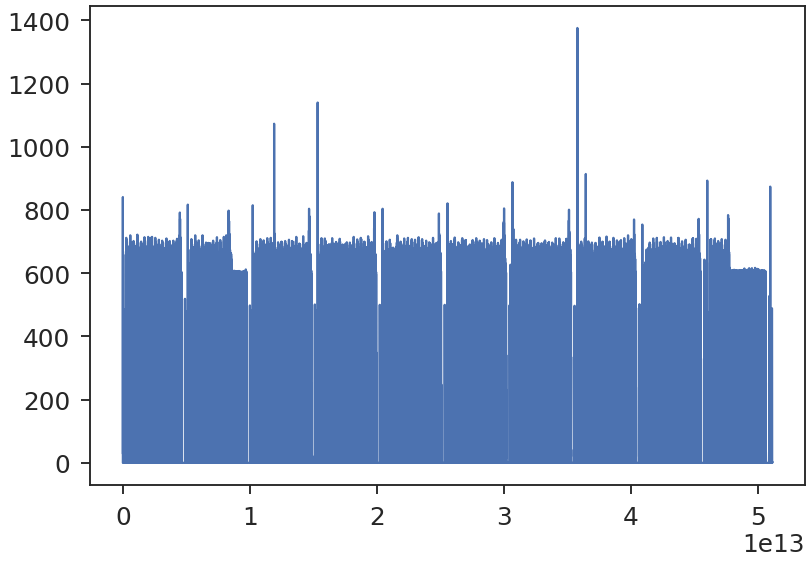

In [541]:
plt.plot(merged.index, merged["page-faults"])

In [542]:
template.merge(merged, on=["instructions"])

,major-faults,minor-faults,page-faults
instructions,,,
64416,0.0,29.596492,29.601634
338666,0.0,170.111518,170.933422
345263,0.0,287.089476,286.817107
351982,0.0,290.745680,290.491360
358536,0.0,292.000000,292.558689
...,...,...,...
51103523446249,0.0,0.000000,0.000000
51103523446249,0.0,0.000000,0.000000
51103523446249,0.0,0.000000,0.000000


In [506]:
template.shape[0] + dfs["657.xz_s.1.llc"].shape[0]

17824345

In [502]:
pd.merge(template, dfs["657.xz_s.1.llc"], how="outer", left_index=True, right_index=True)

,instructions,LLC-load-misses,LLC-loads
0,64416.0,NaN,NaN
1,338666.0,NaN,NaN
2,345263.0,NaN,NaN
3,351982.0,NaN,NaN
4,358536.0,NaN,NaN
...,...,...,...
51103529159896,NaN,12014,17227
51103529159896,NaN,12781,29285
51103529159896,NaN,12050,21924
51103529159896,NaN,9876,22780


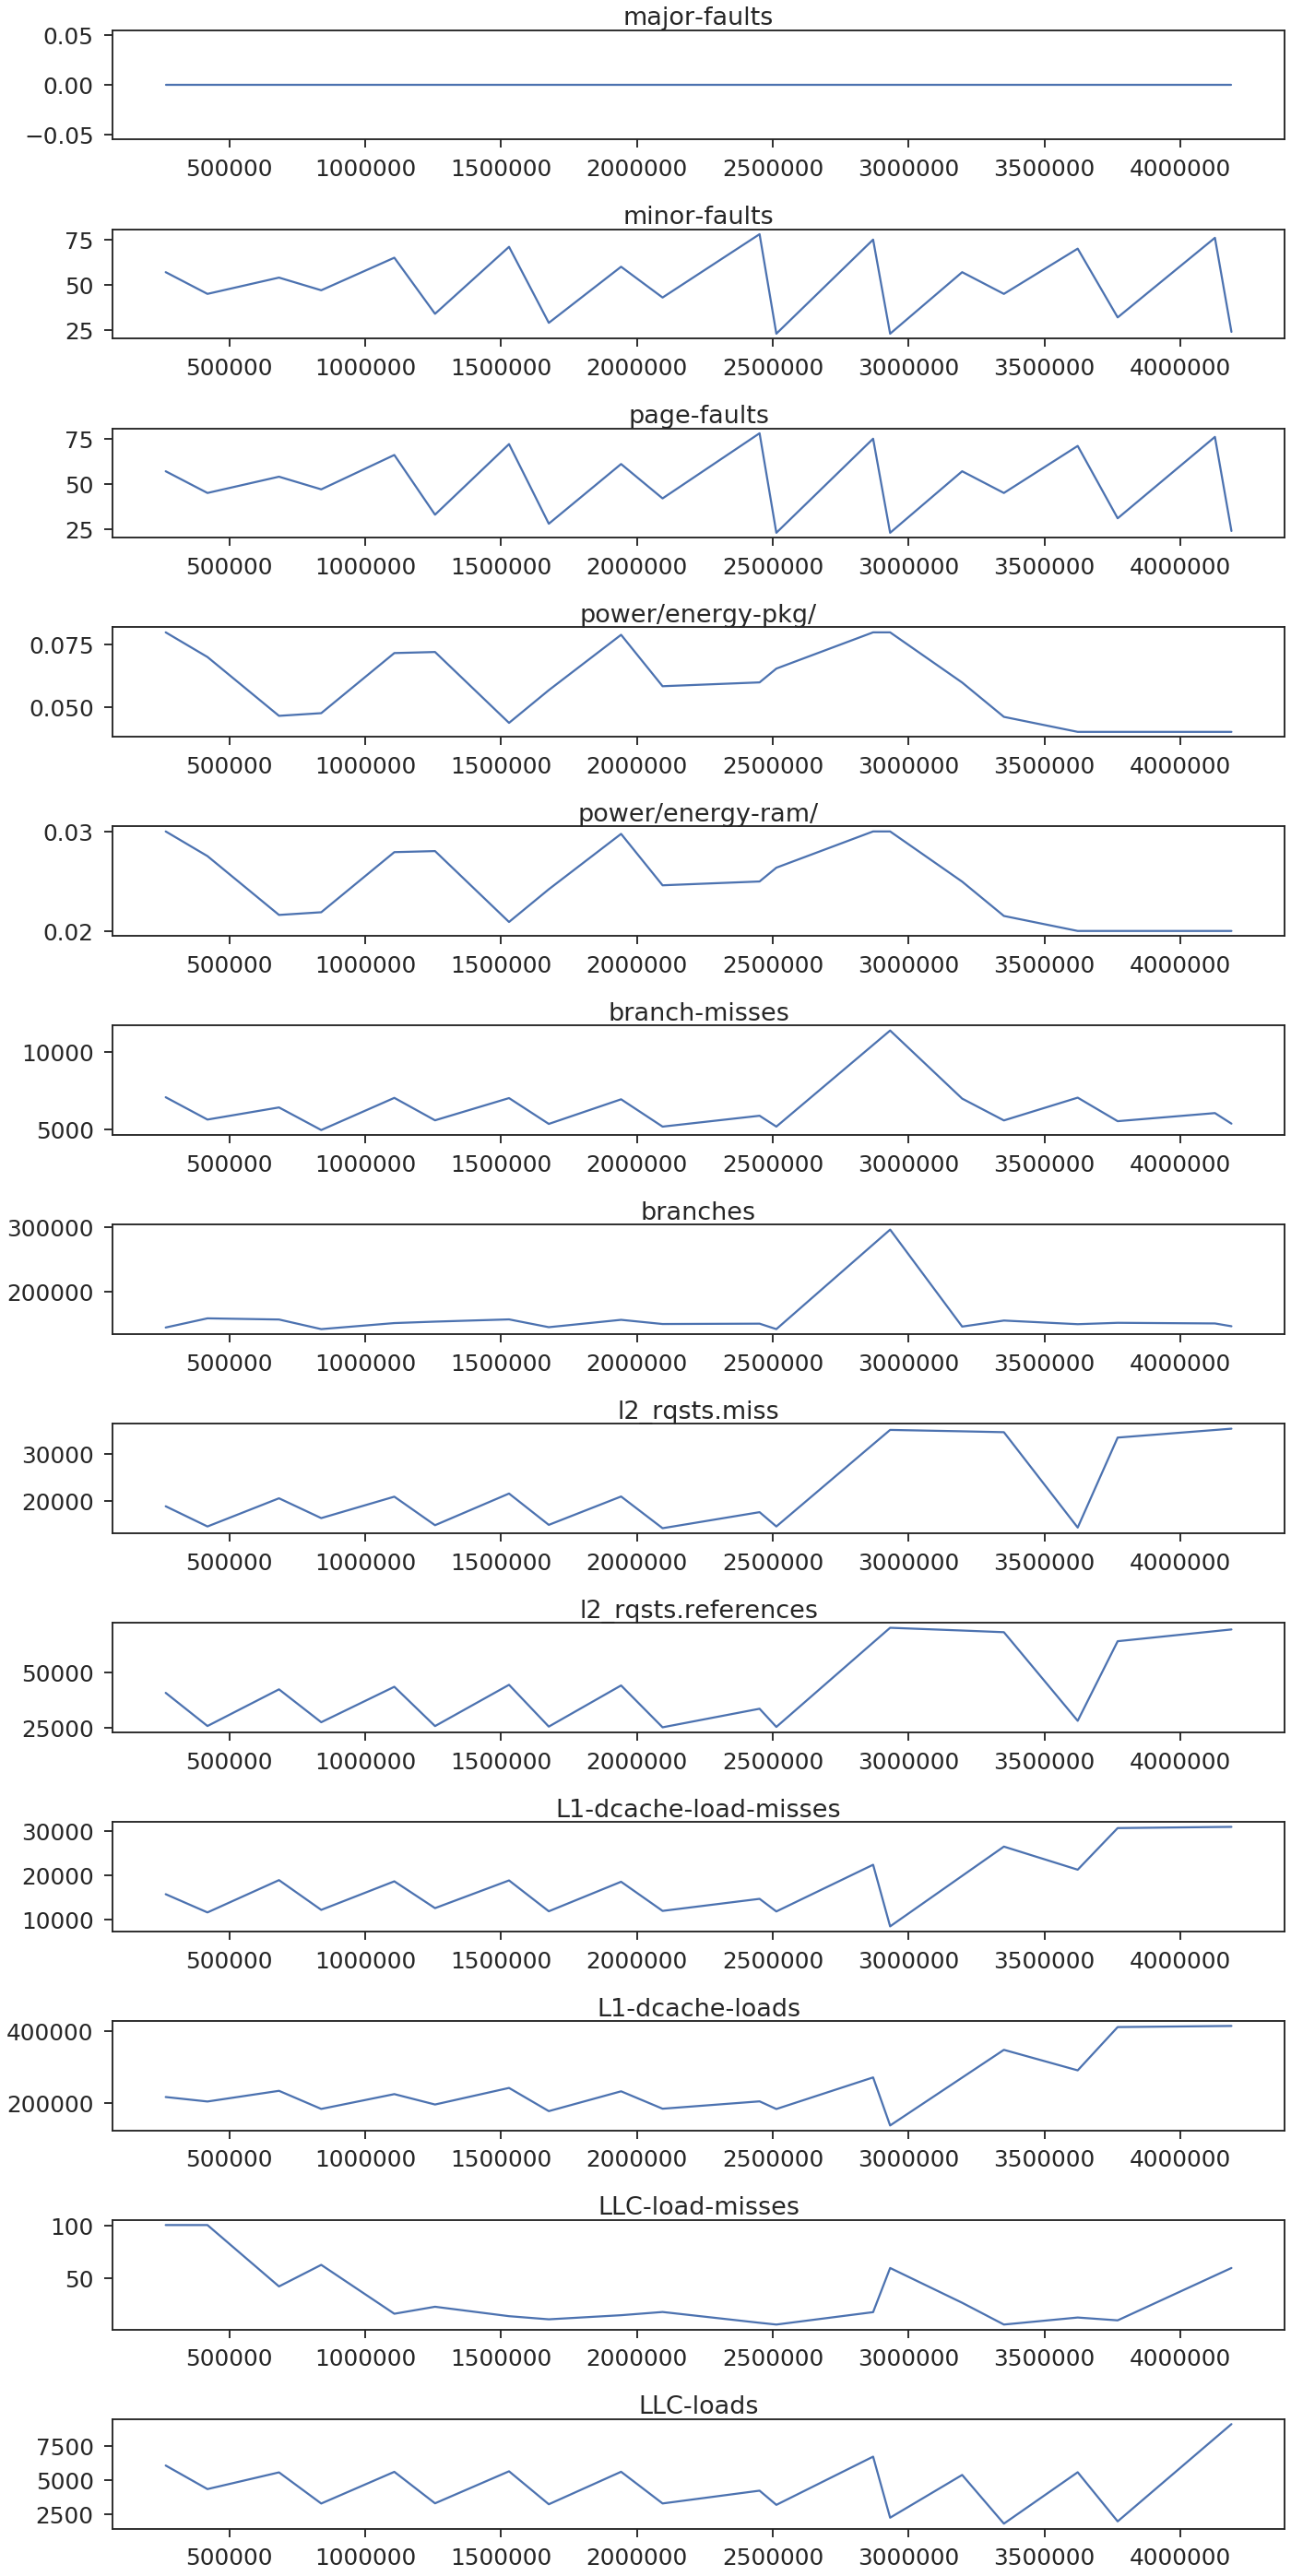

In [435]:
ncols = result.shape[1]
fig, ax = plt.subplots()
fig.set_size_inches(20, 3 * ncols)

for i in range(ncols):
    name = result.columns[i]
    if "instructions" in name:
        continue
    plt.subplot(ncols, 1, i + 1)
    plt.plot(result.index, result[name])
    plt.title(name)

fig.tight_layout(pad=1.0)

## Why are phases important?

In [8]:
scaling_data = pd.read_csv("./csv/scaling.csv")
scaling_data.Scale = scaling_data.Scale.astype(str)

In [9]:
scaling_data

,Scale,TAGE 8KB,TAGE 64KB,Perfect BP,Perfect BP & L1D
0,1,1.00,1.01,1.20,1.50
1,2,1.25,1.27,1.65,2.10
2,4,1.46,1.49,2.04,2.60
3,8,1.60,1.64,2.35,3.04
4,16,1.70,1.75,2.60,3.42
5,32,1.74,1.80,2.80,3.60


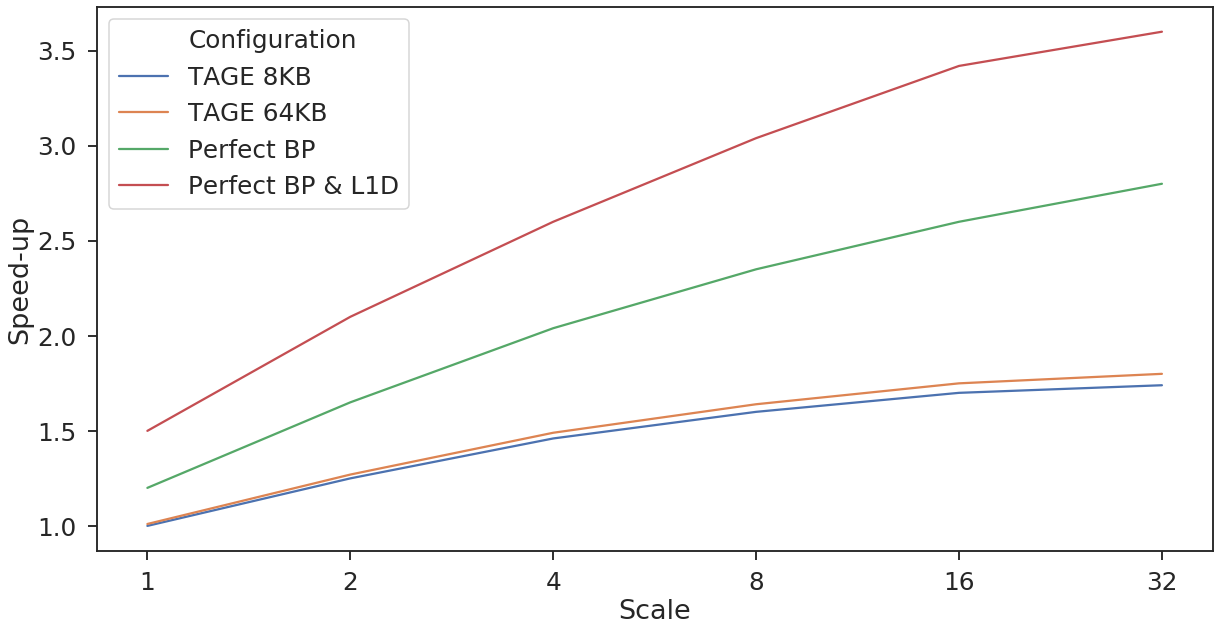

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.lineplot(data=pd.melt(scaling_data, ["Scale"], var_name="Configuration", value_name="Speed-up"), ax=ax, x="Scale",y="Speed-up", hue="Configuration", sort=False)

# Chapter 1: Techniques for online phase classification

## 1. How well does the classifier aid adaptation?

In [11]:
energy_bwaves_data = pd.read_csv("./csv/energy_bwaves.csv")

In [12]:
energy_bwaves_data

,Classifier,KJ
0,Original,34.415
1,SimPoint,35.430
2,BBV,34.100
3,INS,32.500
4,BR,28.100
5,PROC,29.500


Text(0, 0.5, 'Total Energy (KJ)')

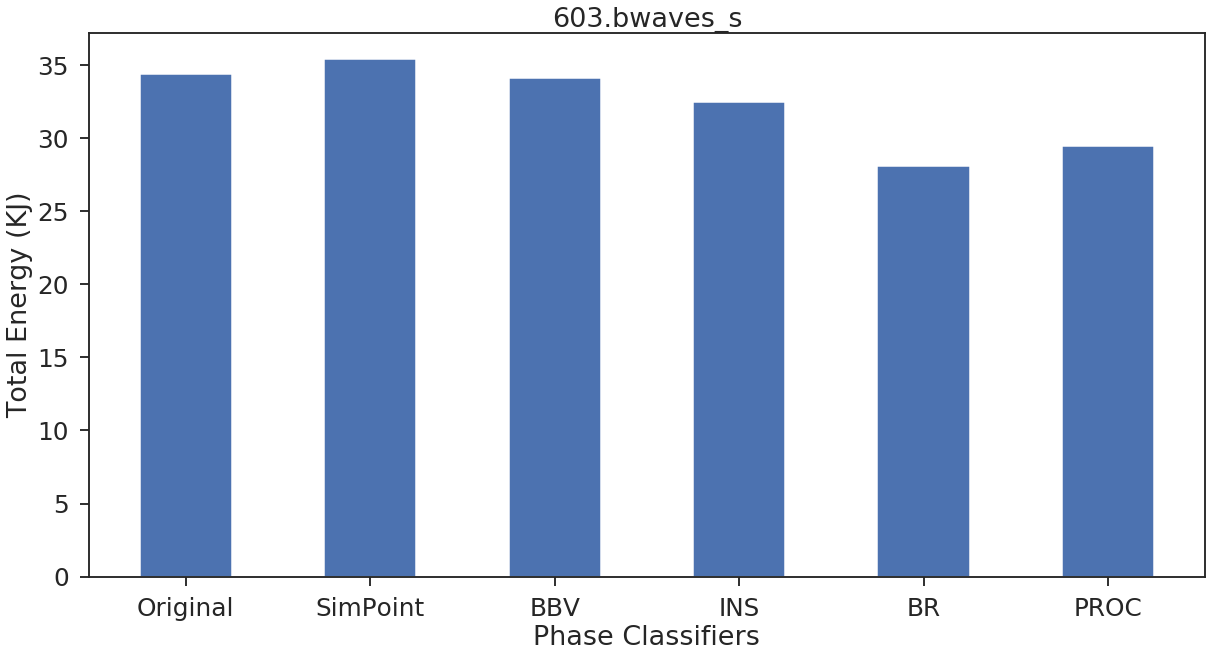

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.bar(energy_bwaves_data.Classifier, energy_bwaves_data.KJ, width=0.5)
plt.title("603.bwaves_s")
plt.xlabel("Phase Classifiers")
plt.ylabel("Total Energy (KJ)")

In [14]:
energy_data = np.random.rand(len(classifiers), len(benchmarks))

In [15]:
energy_data

array([[0.59645147, 0.66214498, 0.81823198, 0.86815828, 0.03265574,
        0.072824  , 0.8438233 , 0.58537296],
       [0.55085595, 0.28993427, 0.38792991, 0.71465057, 0.09990723,
        0.38656086, 0.55253086, 0.35465314],
       [0.15215444, 0.46780459, 0.66244801, 0.47643654, 0.06612469,
        0.22311004, 0.77604457, 0.36600119],
       [0.95470639, 0.91699641, 0.99172855, 0.02247607, 0.88210698,
        0.47930681, 0.0244823 , 0.65807783],
       [0.89748502, 0.63660493, 0.69315573, 0.42309801, 0.52831966,
        0.2456497 , 0.82820441, 0.20334989]])

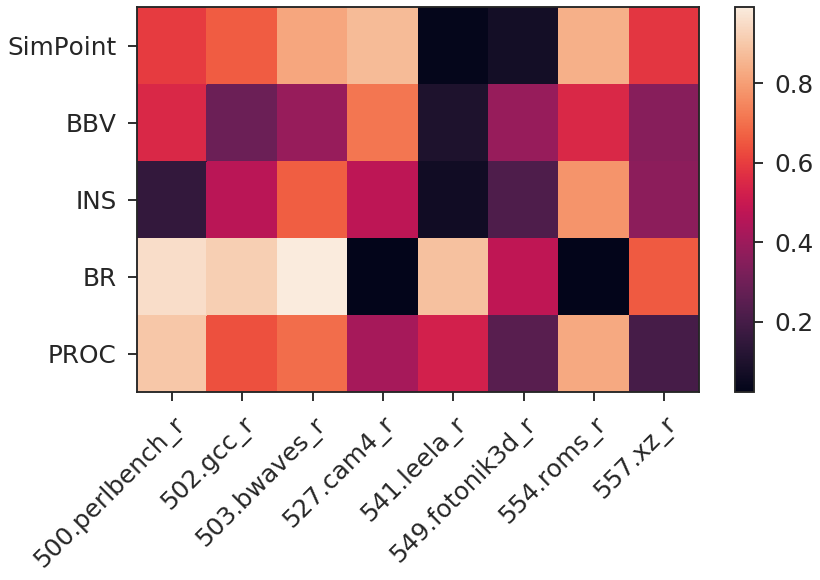

In [16]:
fig, ax = plt.subplots()

# We want to show all ticks...
ax.set_xticks(np.arange(len(benchmarks)))
ax.set_yticks(np.arange(len(classifiers)))

# ... and label them with the respective list entries
ax.set_xticklabels(benchmarks)
ax.set_yticklabels(classifiers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()

ax.set_xticks(np.arange(energy_data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(energy_data.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

plt.colorbar(plt.pcolor(energy_data))

In [17]:
bp_bwaves_data = pd.read_csv("./csv/bp_bwaves.csv")

In [18]:
energy_bwaves_data

,Classifier,KJ
0,Original,34.415
1,SimPoint,35.430
2,BBV,34.100
3,INS,32.500
4,BR,28.100
5,PROC,29.500


Text(0, 0.5, 'Mispredicts per 1K instructions (MPKI)')

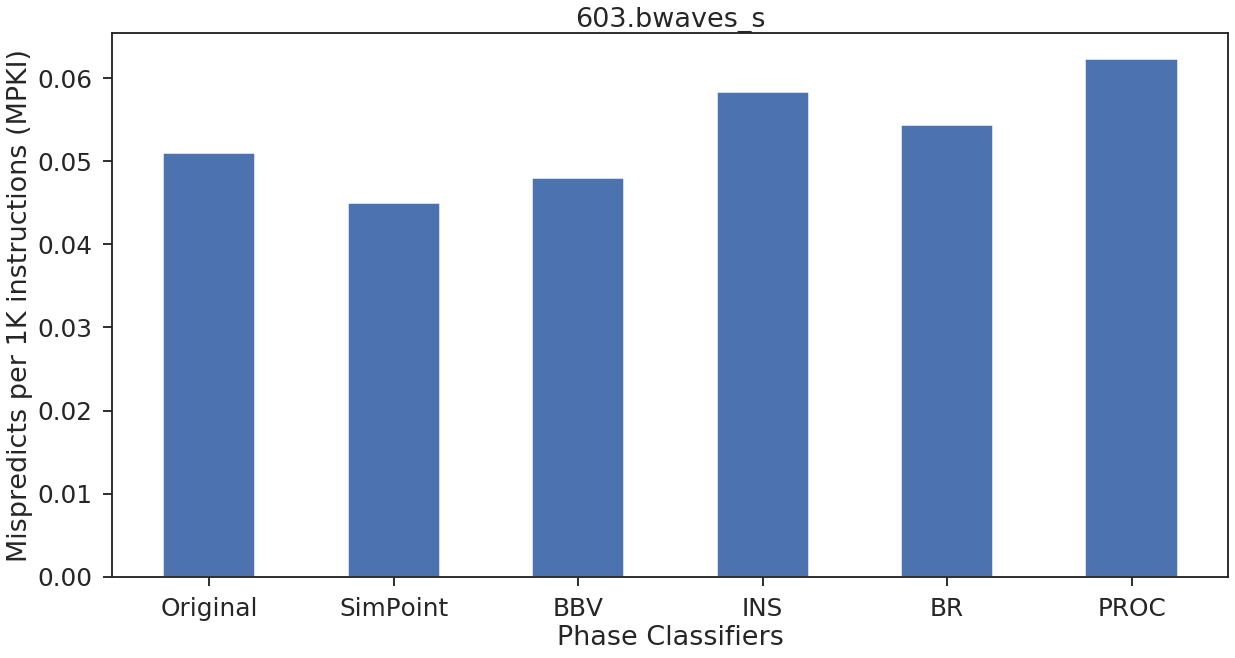

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.bar(bp_bwaves_data.Classifier, bp_bwaves_data.MPKI, width=0.5)
plt.title("603.bwaves_s")
plt.xlabel("Phase Classifiers")
plt.ylabel("Mispredicts per 1K instructions (MPKI)")

In [101]:
bp_data = np.random.rand(len(classifiers), len(benchmarks))

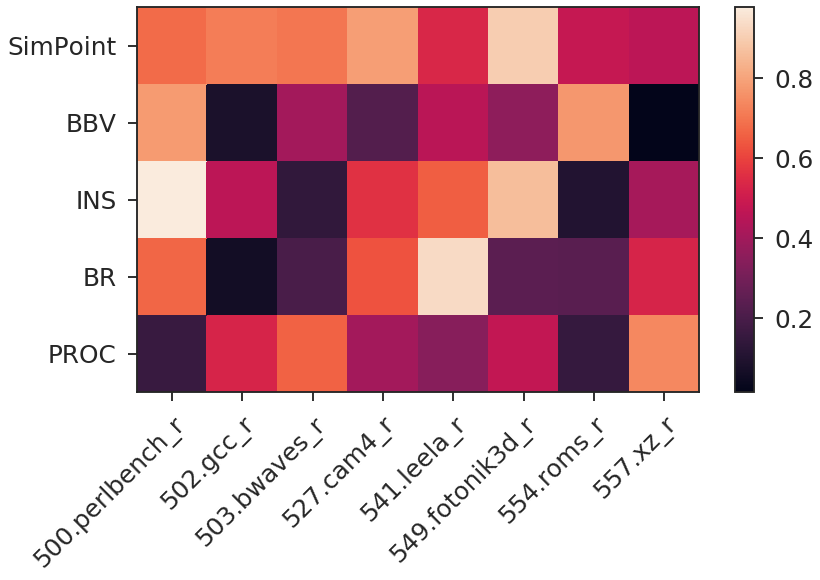

In [102]:
fig, ax = plt.subplots()

# We want to show all ticks...
ax.set_xticks(np.arange(len(benchmarks)))
ax.set_yticks(np.arange(len(classifiers)))

# ... and label them with the respective list entries
ax.set_xticklabels(benchmarks)
ax.set_yticklabels(classifiers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()

ax.set_xticks(np.arange(bp_data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(bp_data.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

plt.colorbar(plt.pcolor(bp_data))

## 2. How well were phases detected

In [20]:
raw_detection_data = pd.read_csv("./csv/detection.csv", sep="\t")
detection_data = raw_detection_data.pct_change()

In [21]:
detection_data

,SimPoint,BBV,INS,BR,PROC
0,NaN,NaN,NaN,NaN,NaN
1,-0.005197,-0.003164,-0.003026,0.002176,-0.022058
2,0.030152,0.025937,0.022049,0.018077,0.019183
3,-0.041783,-0.032261,-0.028896,-0.016345,-0.026287
4,-0.000983,-0.001387,0.003274,-0.005437,-0.002181
...,...,...,...,...,...
995,0.008249,0.004794,0.006539,0.003956,0.004313
996,-0.026706,-0.016438,0.002018,-0.009068,-0.017214
997,0.010233,0.006325,-0.013587,0.002255,0.030371
998,-0.005836,-0.003293,0.029058,0.003832,-0.026871


In [22]:
threshold = 0.02

In [23]:
label_name = "SimPoint"

In [24]:
label = abs(detection_data[label_name]) > threshold

In [25]:
label.value_counts()

False    691
True     309
Name: SimPoint, dtype: int64

In [26]:
tmp = abs(detection_data) > 0.02

In [27]:
tmp

,SimPoint,BBV,INS,BR,PROC
0,False,False,False,False,False
1,False,False,False,False,True
2,True,True,True,False,False
3,True,True,True,False,True
4,False,False,False,False,False
...,...,...,...,...,...
995,False,False,False,False,False
996,True,False,False,False,False
997,False,False,False,False,True
998,False,False,True,False,True


In [28]:
tmp.SimPoint.value_counts()

False    691
True     309
Name: SimPoint, dtype: int64

In [29]:
tmp.BBV.value_counts()

False    813
True     187
Name: BBV, dtype: int64

In [30]:
tmp.eq(label, axis="index").SimPoint.value_counts()

True    1000
Name: SimPoint, dtype: int64

In [31]:
tmp.eq(label, axis="index").BBV.value_counts()

True     826
False    174
Name: BBV, dtype: int64

### True positive

In [32]:
tmp.__and__(label, axis="index").SimPoint.value_counts()

False    691
True     309
Name: SimPoint, dtype: int64

In [33]:
tmp.__and__(label, axis="index").BBV.value_counts()

False    839
True     161
Name: BBV, dtype: int64

### True negative

In [34]:
(~tmp).__and__(~label, axis="index").SimPoint.value_counts()

True     691
False    309
Name: SimPoint, dtype: int64

In [35]:
(~tmp).__and__(~label, axis="index").BBV.value_counts()

True     665
False    335
Name: BBV, dtype: int64

In [36]:
(~tmp).__and__(~label, axis="index").BBV.value_counts()[True]

665

### False positive

In [37]:
tmp.__and__(~label, axis="index").PROC.value_counts()

False    869
True     131
Name: PROC, dtype: int64

### False negative

In [38]:
(~tmp).__and__(label, axis="index").PROC.value_counts()

False    861
True     139
Name: PROC, dtype: int64

### Graph
- For each threshold, compute true positive and false positive
- Organize data as dictionary with classifiers as keys and true/false positive rate data frames

In [140]:
label_thresh = 0.02
label_name = "SimPoint"
label = abs(detection_data[label_name]) > label_thresh

# Get counts of actual positives and actual negatives
cond_pos, cond_neg = label.value_counts()[True], label.value_counts()[False]

In [141]:
print(cond_pos, cond_neg)

309 691


In [142]:
(abs(detection_data) > 0.01).__and__(~label, axis="index").PROC.value_counts()

False    675
True     325
Name: PROC, dtype: int64

In [143]:
(~label).value_counts()

True     691
False    309
Name: SimPoint, dtype: int64

In [144]:
label.value_counts()

False    691
True     309
Name: SimPoint, dtype: int64

In [145]:
results = {}
for col in detection_data:
    results[col] = []
    
for thresh in np.linspace(0, 0.1, num = 101):
    
    # Threshold data
    data = abs(detection_data) > thresh
    tp = data.__and__(label, axis="index")
    fp = data.__and__(~label, axis="index")

    for classifier in data:
        tpr, fpr = 0, 0
        
        tp_vc = tp[classifier].value_counts()
        fp_vc = fp[classifier].value_counts()
        
        if True in tp_vc:
            tpr = tp_vc[True] / cond_pos
        if True in fp_vc:
            fpr = fp_vc[True] / cond_neg

        results[classifier].append({"tpr": tpr, "fpr": fpr})

Text(0, 0.5, 'True positive rate')

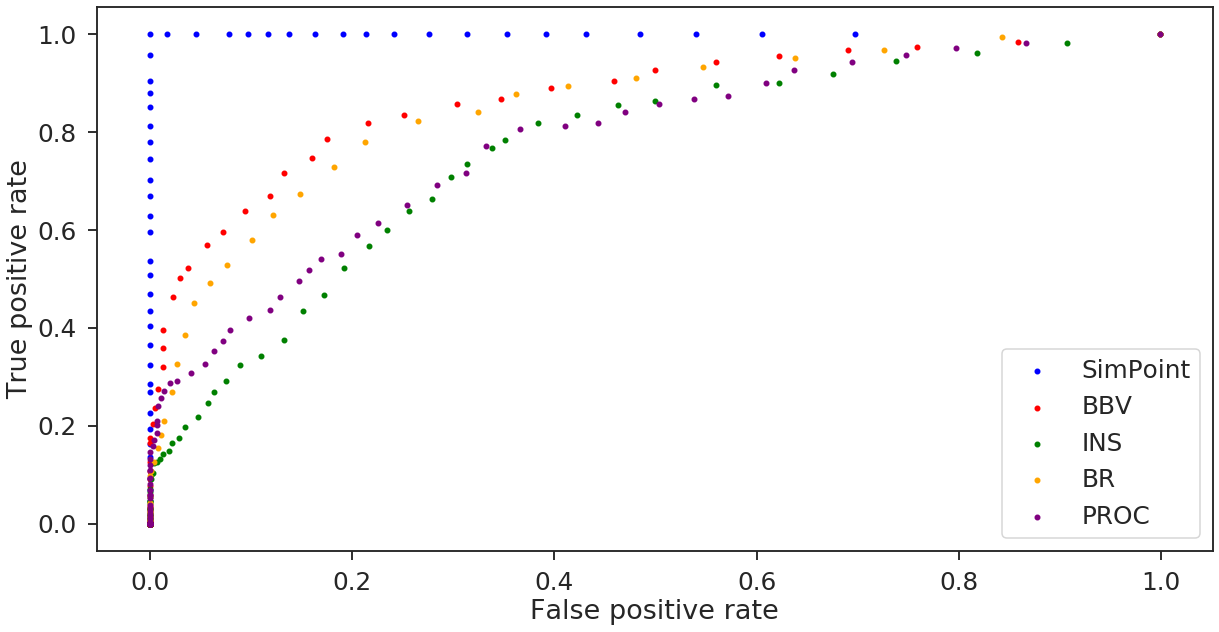

In [150]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

for classifier in detection_data:
#     if col == "SimPoint":
#         continue
    data = pd.DataFrame.from_records(results[classifier])
    data.plot.scatter(x="fpr", y="tpr", color=colors[classifier], ax=ax, label=classifier)
    
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

### Compute AUROC

In [183]:
auroc = {}
for classifier in detection_data:
    data = pd.DataFrame.from_records(results[classifier])
    data["index"] = data.index
    data = data.sort_values(by=["fpr", "index"], ascending=[True, False])
    auroc[classifier] = ((data.tpr.shift() + data.tpr) / 2 * data.fpr.diff()).sum()
    
auroc = pd.DataFrame.from_dict(auroc, orient="index", columns=["AUROC"])

In [190]:
[colors[classifier] for classifier in classifiers]

['blue', 'red', 'green', 'orange', 'purple']

([<matplotlib.axis.XTick at 0x7f02ffc12810>,
 <a list of 5 Text xticklabel objects>)

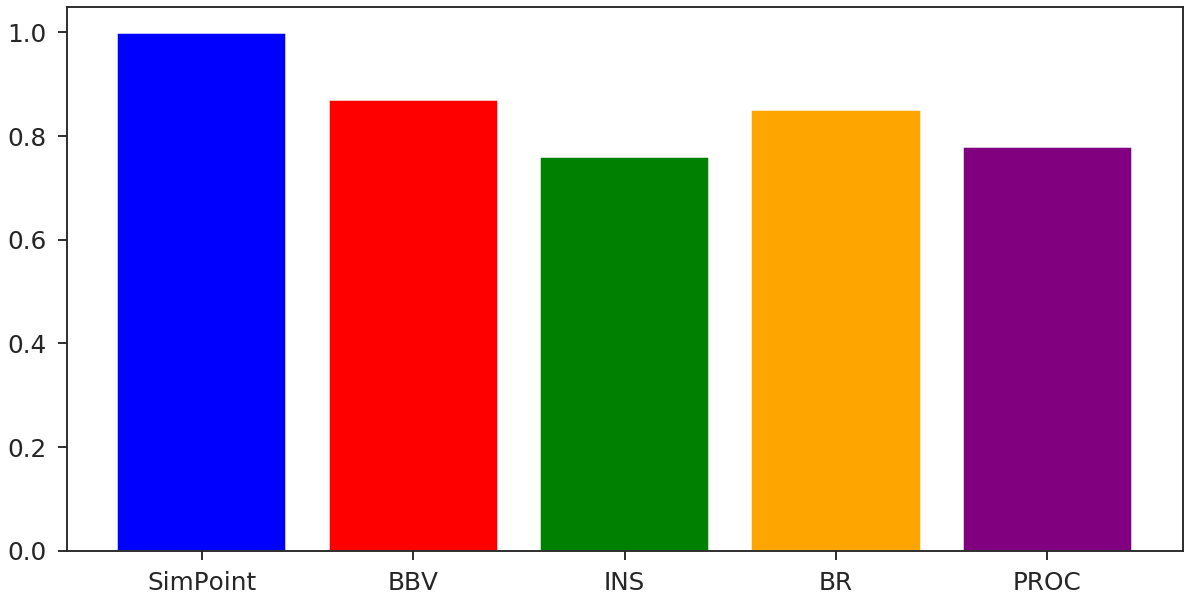

In [198]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.bar(np.arange(len(classifiers)), auroc.AUROC, color=[colors[classifier] for classifier in classifiers])
plt.xticks(np.arange(len(classifiers)), classifiers)

## 3. How well were phases classified

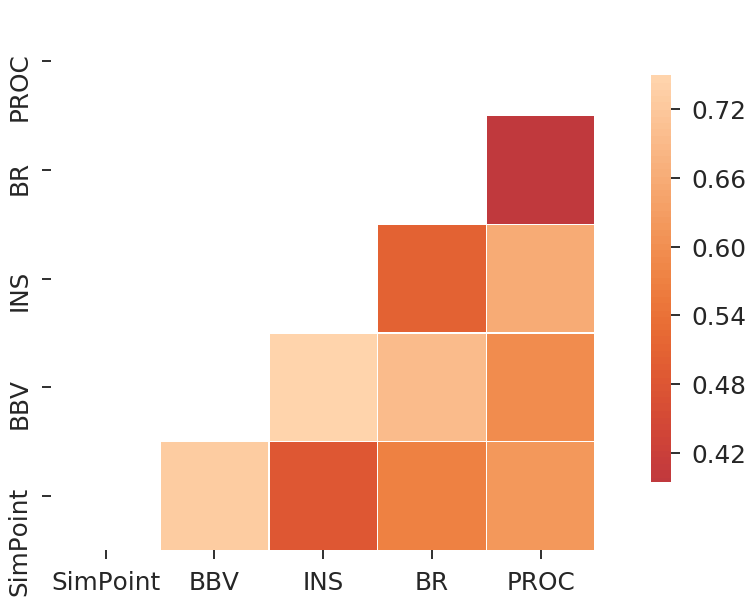

In [134]:
# Generate a large random dataset
rs = np.random.rand(100, len(classifiers))
d = pd.DataFrame(data=rs,
                 columns=classifiers)

# Compute the correlation matrix
corr = d.corr().iloc[::-1, :]

dummy = np.random.normal(0.6, 0.1, size=(len(classifiers), len(classifiers)))
corr[corr.columns] = dummy

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
mask[(np.triu_indices_from(mask)[0], 4 - np.triu_indices_from(mask)[1])] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75})

In [120]:
corr.columns

,SimPoint,BBV,INS,BR,PROC
PROC,-0.101291,-0.118442,-0.115512,0.193939,1.000000
BR,-0.002178,-0.080660,-0.151633,1.000000,0.193939
INS,-0.005328,-0.012275,1.000000,-0.151633,-0.115512
BBV,-0.064399,1.000000,-0.012275,-0.080660,-0.118442
SimPoint,1.000000,-0.064399,-0.005328,-0.002178,-0.101291


## 5. How long/stable are the phases

### Stability

In [58]:
stability_data = pd.read_csv("./csv/stability.csv", sep="\t")

In [59]:
stability_data

,SimPoint,BBV,INS,BR,PROC
0,63.650144,24.0,38.0,44.300000,60.0
1,64.596791,39.0,53.0,53.400000,61.0
2,63.876748,48.0,55.0,56.000000,63.0
3,69.027538,54.0,59.0,59.000000,66.0
4,70.404641,59.0,60.0,59.615679,67.0
5,69.702777,63.0,61.2,59.242779,68.0
6,71.232799,67.0,62.0,61.226969,68.3
7,70.781106,70.0,63.5,61.681983,68.6
8,80.240394,72.0,64.5,62.795548,68.8
9,77.842052,73.7,66.0,64.500000,69.0


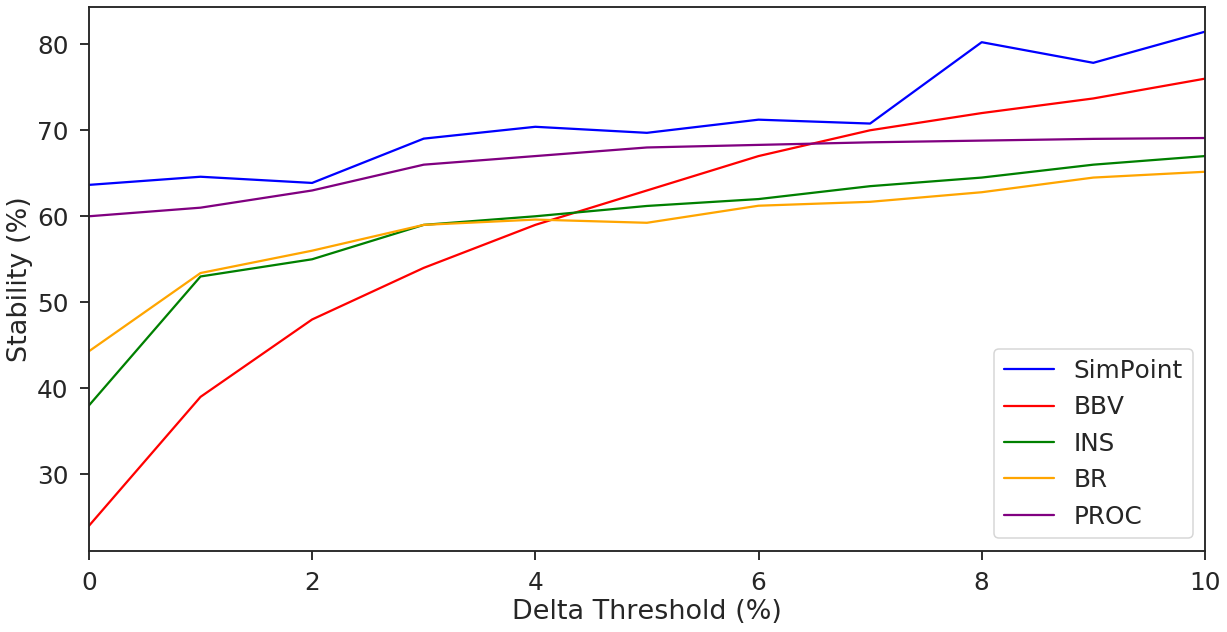

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

for col in stability_data:
    stability_data[col].plot.line(color=colors[col], ax=ax, label=col)
    
plt.xlabel("Delta Threshold (%)")
plt.ylabel("Stability (%)")
plt.legend()

### Length

In [69]:
length_data = pd.read_csv("./csv/length.csv", sep="\t")

In [70]:
length_data

,SimPoint,BBV,INS,BR,PROC
0,8.327689,0.0,4.5,4.56,9.40
1,8.712689,4.3,5.4,5.40,9.20
2,9.262689,5.1,6.1,6.10,9.50
3,9.757689,5.8,6.4,6.90,10.10
4,10.384689,6.1,7.4,7.60,10.24
5,10.478189,6.4,7.5,7.60,10.31
6,10.687189,6.8,7.9,7.80,10.29
7,10.659689,7.1,7.8,7.60,10.34
8,10.500189,7.8,7.5,7.50,10.35
9,10.852189,8.9,8.1,7.40,10.39


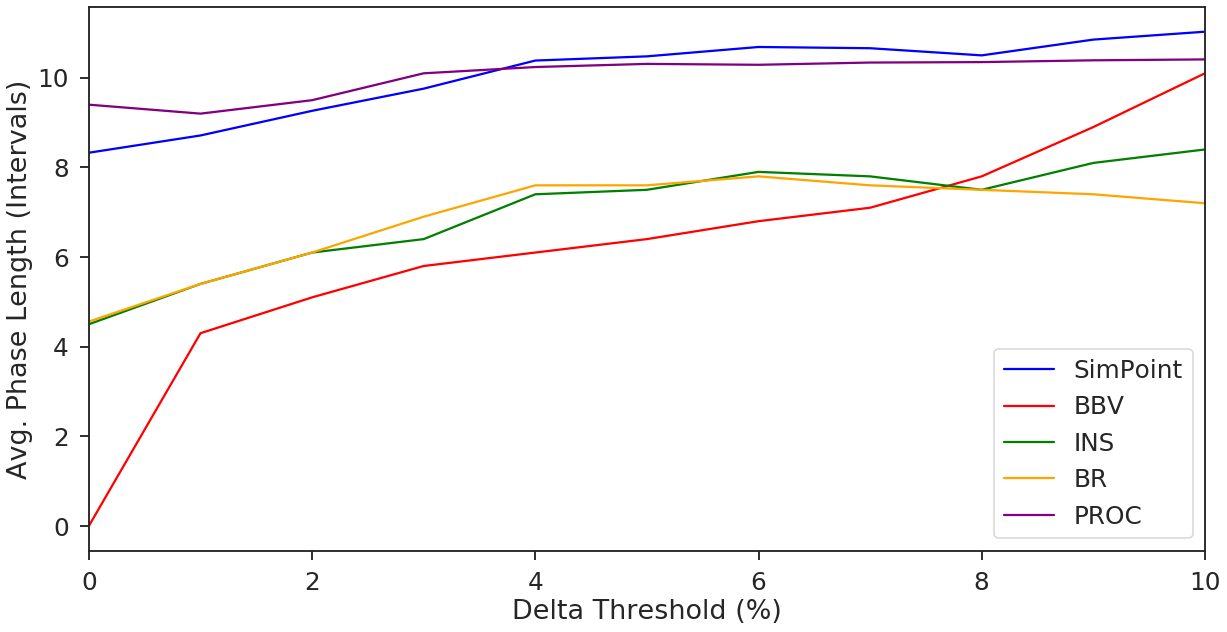

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

for col in length_data:
    length_data[col].plot.line(color=colors[col], ax=ax, label=col)
    
plt.xlabel("Delta Threshold (%)")
plt.ylabel("Avg. Phase Length (Intervals)")
plt.legend()

## 6. How representative are the phases

In [76]:
representative_data = pd.read_csv("./csv/representative.csv", sep="\t", index_col=0)

In [94]:
representative_data

,Start 0,Start 1bn,BBV
gzip,68,13,4
gcc,51,33,8
bwaves,57,34,11
med,58,23,2
max,100,100,11


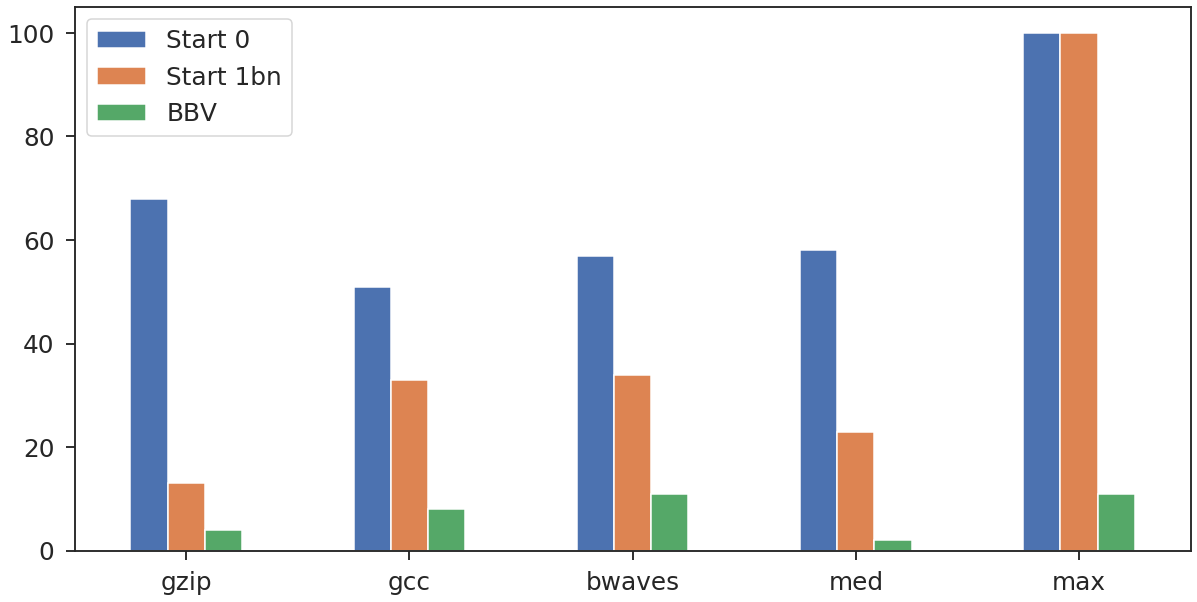

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

representative_data.plot.bar(rot=0, ax=ax)

# Chapter 2: Challenges and opportunities

## 1. Use fixed, non-overlapping windows

### Simple example

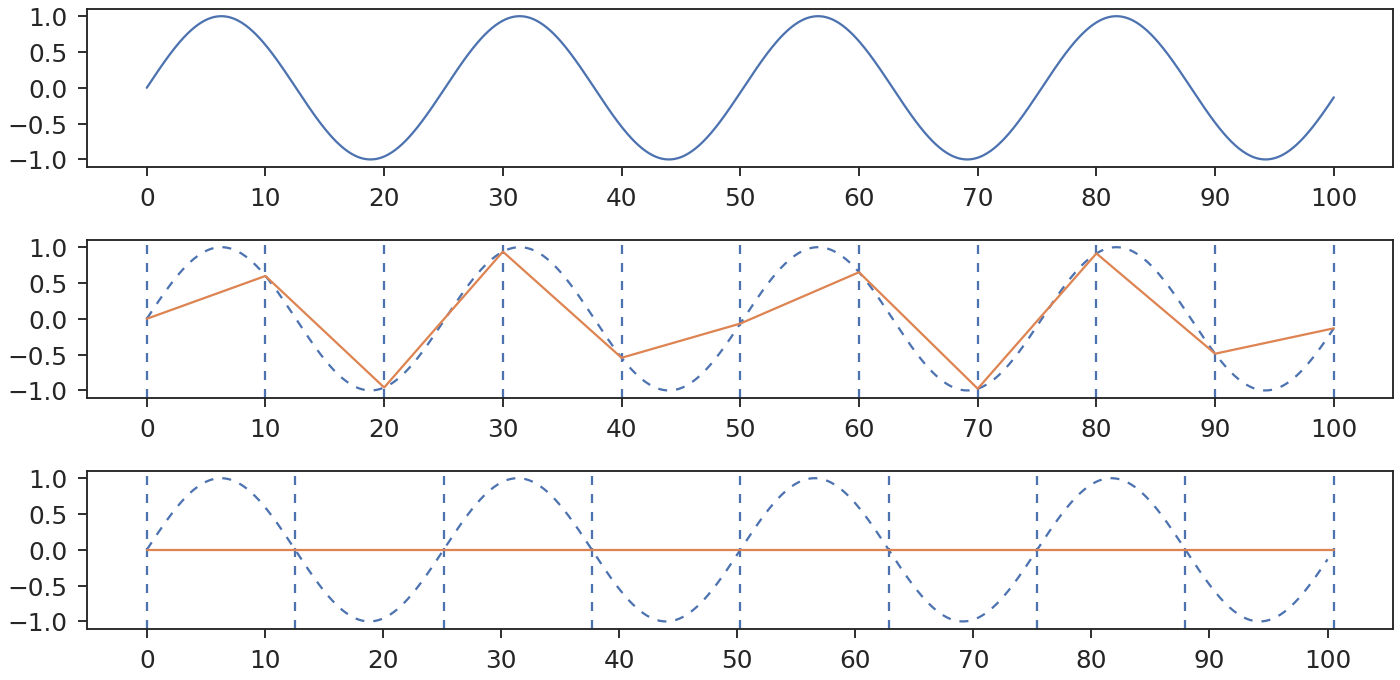

In [275]:
xs = np.linspace(0, 100, 1001)
sin = np.sin((xs + 10) * (np.pi) / 10)
sin = np.sin(xs / 4)

dashes = (4, 4, 4, 4)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

plt.subplot(3, 1, 1)
plt.plot(xs, sin)
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(-1, 1, 5))

plt.subplot(3, 1, 2)
plt.plot(xs, sin, dashes=dashes)
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(-1, 1, 5))

for i in np.linspace(0, 100, 11):
    plt.axvline(x=i, ymin=0, ymax=1, dashes=dashes)

plt.plot(np.linspace(0, 100, 11), np.sin(np.linspace(0, 100, 11) / 4))

plt.subplot(3, 1, 3)
plt.plot(xs, sin, dashes=dashes)
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(-1, 1, 5))
for i in np.arange(0, 101, 4 * np.pi):
    plt.axvline(x=i, ymin=0, ymax=1, dashes=dashes)
    
plt.plot(np.arange(0, 101, 4 * np.pi), np.sin(np.arange(0, 101, 4 * np.pi)))

fig.tight_layout(pad=1.0)